This is a code written to Stack Spectra using SPARCL on Astro Data Lab's online Jupyter Notebook

website: https://datalab.noirlab.edu/about.php

In [1]:
# import sparcl.client
from sparcl.client import SparclClient

# import the required libraries
import numpy as np
import astropy as astro
from astropy.io import fits
import astropy.units as u
from specutils import Spectrum1D
from astropy.nddata import InverseVariance
from astropy.convolution import convolve, Gaussian1DKernel
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# import for SPARCL login
from dl import queryClient as qc
from dl import authClient as ac
from getpass import getpass

# for getting standard plots
plt.rc_context({'lines.linewidth': 1, 'lines.linestyle': '-'})
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (14,8)

First send a request for creation of account to Astro Data Lab on the website link above

In [2]:
# code to login to Astro Data Lab
token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

Enter user name: (+ENTER)  kkr_iiser
Enter password: (+ENTER)  ········


'kkr_iiser'

In [3]:
# set the client to SPARCL
client = SparclClient()
client

(sparclclient:1.2.1, api:11.0, https://astrosparcl.datalab.noirlab.edu/sparc, client_hash=, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

In [4]:
# out are the fields you want to view
out = ['sparcl_id', 'redshift', 'data_release']

# cons are the coditions that you can set
cons = {'spectype': ['QSO'],# Can be set to 'GALAXY', 'QSO', 'sTAR' 
        'data_release': ['BOSS-DR16'],# can be set to 'SDSS-DR16', 'BOSS-DR16', 'DESI-EDR'
        'redshift': [0.6, 1.1]}# can be set to any range

# points are the number of Galaxies/QSOs/Stars you want the data for
points = 10

# sort puts the data in order
found_I = client.find(outfields=out, constraints=cons, limit=points, sort='redshift')

# put more %s, %f for string and float accordingly for other outfields you want
["%s, %s, %f" % (f.sparcl_id, f.data_release, f.redshift)
for f in found_I.records]

['8a14706d-a225-11ee-ab70-525400ad1336, BOSS-DR16, 0.600003',
 'd52192b8-9f9e-11ee-964b-525400ad1336, BOSS-DR16, 0.600003',
 '86e5d762-a121-11ee-a153-525400ad1336, BOSS-DR16, 0.600005',
 '33b345ef-9ef4-11ee-8b6d-525400ad1336, BOSS-DR16, 0.600007',
 '858bda7e-a4fc-11ee-9c42-525400ad1336, BOSS-DR16, 0.600008',
 '413609b4-a379-11ee-b037-525400ad1336, BOSS-DR16, 0.600017',
 '28cb25eb-a036-11ee-9b0f-525400ad1336, BOSS-DR16, 0.600017',
 'f135a72f-a30c-11ee-8b0e-525400ad1336, BOSS-DR16, 0.600020',
 'a6d30e0b-a43b-11ee-b6a3-525400ad1336, BOSS-DR16, 0.600020',
 '9cf4c5c6-9eb4-11ee-9042-525400ad1336, BOSS-DR16, 0.600021']

In [5]:
# 'inc' tells the required details to be included in the result
inc = ['sparcl_id', 'data_release', 'redshift', 'flux', 'wavelength']

# list down all the IDs in the data found
ids_I = found_I.ids

# retrieve the details listed in 'inc' for IDs in uuid_list
results_I = client.retrieve(uuid_list=ids_I, include=inc)
results_I.info

{'status': {'success': True,
  'info': ["Successfully found 10 records in dr_list=['DESI-EDR', 'BOSS-DR16', 'SDSS-DR16', 'SDSS-DR17']"],
  'warnings': []}}

In [8]:
# first use this function to sharten the results to fit in the wanted wavelength range

# take minimum & maximum wavelength (min_wave & max_wave) in Angstrom
# put limit = points
def lengthen(results, limit, min_wave, max_wave):

    # this part coverts inputs
    no_min = float(min_wave)
    no_max = float(max_wave)
    index = int(limit)
    arr_fix_wv =[]

    for k in range(index):
        # this part is retreiving data
        records = results.records[k]
        wavelength = records.wavelength
        flux = records.flux

        # this part is making matrices of all the values and then form its array
        arr_wave_flux = [[wavelength[i],flux[i]] for i in range(len(wavelength))]

        # this part will remove all data points outside of minimum wavelength to maximum wavelength
        # giving flux for a fixed range of wavelengths
        for x in range(len(arr_wave_flux)):
            if no_min <= arr_wave_flux[x][0] <= no_max :
                arr_fix_wv.append(arr_wave_flux[x])

    return arr_fix_wv

In [18]:
# use this function to form bin of wanted size and then placing flux in respective bins as an array
def binning(arr_fix_wv, bin_size_in, min_wave, max_wave):

    no_min = float(min_wave)
    no_max = float(max_wave)
    bin_size = float(bin_size_in)
    
    no_of_bins = int(np.ceil((no_max - no_min) / bin_size)) + 1
    new_bins = np.linspace(no_min, no_max, no_of_bins)
    bin_mids = np.mean(np.vstack([new_bins[:-1], new_bins[1:]]), axis=0)

    # this part is for putting flux according to rebinned data into an array
    binned_flux = []
    
    for n in range(no_of_bins-1):
        flux_list = []
        for i in range(len(arr_fix_wv)):
            if new_bins[n] <= arr_fix_wv[i][0] <= new_bins[n+1]:
                flux_list.append(arr_fix_wv[i][1])
        binned_flux.append(flux_list)

    return binned_flux, new_bins, bin_mids

In [20]:
# use this function to take out mean of all flux values for every bin
def mean_flux(binned_flux):
    mean_flux_array = []
    
    for i in range(len(binned_flux)):
        sum_of_flux = 0
        for j in range(len(binned_flux[i])):
            sum_of_flux = sum_of_flux + binned_flux[i][j]
        if len(binned_flux[i]) != 0:   
            mean_of_flux = sum_of_flux / len(binned_flux[i])
            mean_flux_array.append(mean_of_flux)
        else: mean_flux_array.append(0)

    return mean_flux_array

In [22]:
# set results = results_I (as above)
# set limit = points (as above)
# set min_wave and max_wave in Angstrom then use in lengthen function
minimum_wave = 3600
maximum_wave = 10300

fixed_wave_flux = lengthen(results=results_I,
                           limit=points,
                           min_wave=minimum_wave,
                           max_wave=maximum_wave)

# set min_wave and max_wave (same as above)
# set wave_bin_size as per your requirement 
wave_bin_size = 3
seperated_flux, bin_edges, bin_centers = binning(arr_fix_wv=fixed_wave_flux,
                                                 bin_size_in=wave_bin_size,
                                                 min_wave=minimum_wave,
                                                 max_wave=maximum_wave)

# this is the satcked data that can be plotted
final_flux = mean_flux(binned_flux=seperated_flux)

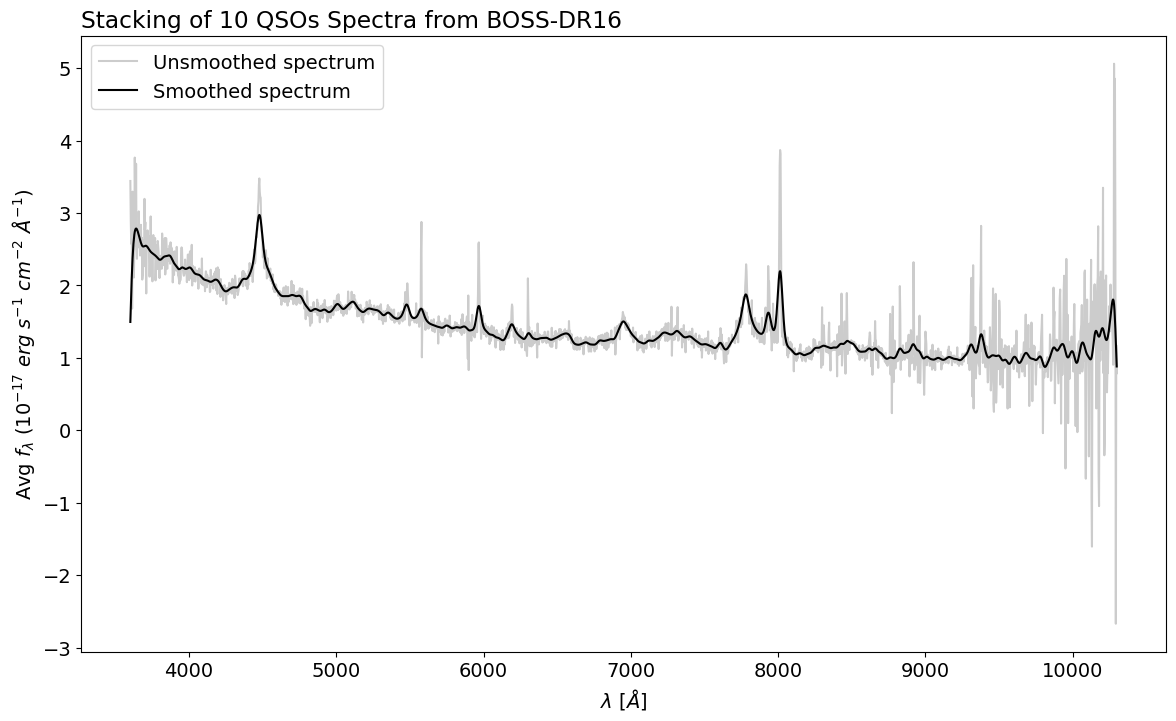

In [23]:
plt.plot(bin_centers, final_flux, color='k', alpha=0.2, label='Unsmoothed spectrum')
plt.plot(bin_centers, convolve(final_flux, Gaussian1DKernel(5)), color='k', label='Smoothed spectrum')

plt.title('Stacking of 10 QSOs Spectra from BOSS-DR16',loc='left')
plt.xlabel('$\lambda\ [\AA]$')
plt.ylabel('Avg $f_{\lambda}$ $(10^{-17}$ $erg$ $s^{-1}$ $cm^{-2}$ $\AA^{-1})$')
    
plt.legend()
plt.show()